# 【練習問題】健診データによる肝疾患判定

In [225]:
# モジュールの読み込み
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

sns.set()
sns.set_style('whitegrid')

# Googleマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
# データの読み込み
df = pd.read_csv("/content/drive/MyDrive/1,データコンペ/SIGNATE/健診データによる肝疾患判定/train.csv")
sub_test = pd.read_csv("/content/drive/MyDrive/1,データコンペ/SIGNATE/健診データによる肝疾患判定/test.csv")

In [227]:
df.shape

(891, 12)

In [228]:
df.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


In [229]:
df = df.drop('id', axis=1)
sub_test = sub_test.drop('id', axis=1)

In [230]:
df.describe()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,887.000000,891.000000
mean,43.340067,2.807856,1.256790,268.607071,63.770146,81.336139,6.537823,3.230752,0.997858,0.483726
std,16.647096,4.922115,2.578286,226.134887,154.295258,175.539331,1.030673,0.748239,0.302247,0.500016
min,3.000000,0.400000,0.100000,63.000000,9.900000,10.100000,2.600000,0.900000,0.310000,0.000000
25%,31.000000,0.800000,0.200000,170.450000,21.900000,22.900000,5.900000,2.700000,0.810000,0.000000
50%,44.000000,1.100000,0.400000,198.000000,30.000000,35.000000,6.600000,3.200000,0.990000,0.000000
75%,57.000000,2.100000,0.900000,279.000000,51.400000,68.000000,7.300000,3.800000,1.165000,1.000000
max,90.000000,43.200000,19.800000,2110.100000,2000.200000,2946.000000,9.600000,5.600000,2.970000,1.000000


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       891 non-null    int64  
 1   Gender    891 non-null    object 
 2   T_Bil     891 non-null    float64
 3   D_Bil     891 non-null    float64
 4   ALP       891 non-null    float64
 5   ALT_GPT   891 non-null    float64
 6   AST_GOT   891 non-null    float64
 7   TP        891 non-null    float64
 8   Alb       891 non-null    float64
 9   AG_ratio  887 non-null    float64
 10  disease   891 non-null    int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 76.7+ KB


In [232]:
df.isnull().sum()

Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64

In [233]:
df["AG_ratio"].fillna(df["Alb"] / (df["TP"] - df["Alb"]), inplace=True)

In [234]:
#重複部分の削除
df.drop_duplicates(inplace=True)

#重複部分の削除の後に新しいインデックスを取得。
df.reset_index(drop=True, inplace=True)

In [235]:
df.shape

(891, 11)

In [236]:
# カテゴリ変数の列名をリストで指定
col_categoric = ["Gender", "disease"]

#数量変数のデータフレームを作成し、printで確認
df_numeric = df.drop(col_categoric, axis=1)
print(df_numeric)

#カテゴリ変数のデータフレームを作成し、printで確認
df_categoric = df[col_categoric]
print(df_categoric)

     Age  T_Bil  D_Bil    ALP  ALT_GPT  AST_GOT   TP  Alb  AG_ratio
0     60    2.9    1.3  170.9     42.1     37.1  5.5  2.9      1.01
1     28    0.7    0.1  158.8     26.0     23.9  6.4  3.7      1.36
2     60   23.1   12.5  962.0     53.0     40.9  6.8  3.3      0.96
3     20    1.0    0.5  415.9     33.9     39.0  7.0  3.8      1.31
4     44    0.6    0.3  152.9     40.9     42.0  4.5  2.1      1.04
..   ...    ...    ...    ...      ...      ...  ...  ...       ...
886   31    0.7    0.3  164.2     30.0     29.0  6.2  3.0      1.07
887   57    1.0    0.3  130.1     23.9     25.0  6.9  4.1      1.28
888   54   23.5   12.7  574.0     43.1     47.0  7.2  3.4      0.84
889   24    1.2    0.4  130.0     23.2     42.0  8.1  3.9      0.87
890   57    1.9    0.8  270.8     40.8     50.0  6.0  2.8      0.94

[891 rows x 9 columns]
     Gender  disease
0      Male        1
1    Female        0
2      Male        1
3      Male        0
4    Female        0
..      ...      ...
886    Male  

In [237]:
#disease列のカテゴリ（疾患なし:0 または 疾患あり:1）の個数を調べる
print(df_categoric["disease"].value_counts())

0    460
1    431
Name: disease, dtype: int64


0    460
1    431
Name: disease, dtype: int64


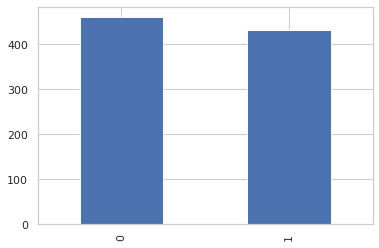

In [238]:
#disease列の各カテゴリのデータ数を取得し、printで表示
counts_disease = df_categoric["disease"].value_counts()
print(counts_disease)

#棒グラフによる可視化
counts_disease.plot(kind='bar')
plt.show()

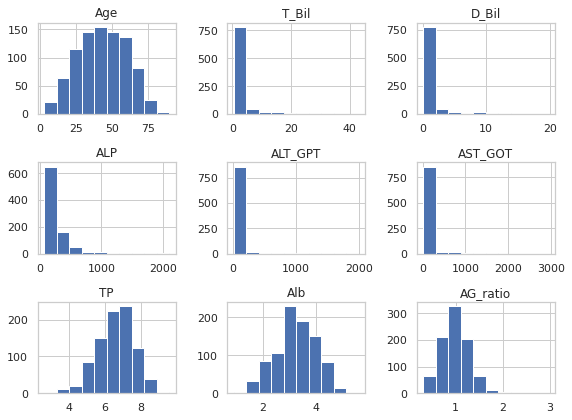

In [239]:
#数量変数のヒストグラムを表示(※figsizeオプションはグラフのサイズを指定）
df_numeric.hist(figsize=(8, 6))

# グラフのラベルが重ならないようにレイアウトを自動調整
plt.tight_layout()
plt.show()

In [240]:
# df_categoric内の"disease"列と、df_numericの列を横結合する
df_tmp = pd.concat([df_categoric["disease"], df_numeric], axis=1)

# 結合したデータフレームの最初の5行を表示
print(df_tmp.head(5))

   disease  Age  T_Bil  D_Bil    ALP  ALT_GPT  AST_GOT   TP  Alb  AG_ratio
0        1   60    2.9    1.3  170.9     42.1     37.1  5.5  2.9      1.01
1        0   28    0.7    0.1  158.8     26.0     23.9  6.4  3.7      1.36
2        1   60   23.1   12.5  962.0     53.0     40.9  6.8  3.3      0.96
3        0   20    1.0    0.5  415.9     33.9     39.0  7.0  3.8      1.31
4        0   44    0.6    0.3  152.9     40.9     42.0  4.5  2.1      1.04


In [241]:
# diseaseの値が0（疾患なし）のサンプルを表示（最初の5行を表示）
print(df_tmp.query("disease == 0").head(5))

# diseaseの値が1（疾患あり）のサンプルを表示（最初の5行を表示）
print(df_tmp.query("disease==1").head(5))

   disease  Age  T_Bil  D_Bil    ALP  ALT_GPT  AST_GOT   TP  Alb  AG_ratio
1        0   28    0.7    0.1  158.8     26.0     23.9  6.4  3.7      1.36
3        0   20    1.0    0.5  415.9     33.9     39.0  7.0  3.8      1.31
4        0   44    0.6    0.3  152.9     40.9     42.0  4.5  2.1      1.04
7        0   37    0.8    0.1  152.0     89.9     20.9  7.0  4.3      1.43
8        0   41    0.9    0.2  114.0     20.9     22.9  7.0  3.1      1.04
   disease  Age  T_Bil  D_Bil    ALP  ALT_GPT  AST_GOT   TP  Alb  AG_ratio
0        1   60    2.9    1.3  170.9     42.1     37.1  5.5  2.9      1.01
2        1   60   23.1   12.5  962.0     53.0     40.9  6.8  3.3      0.96
5        1   62   11.1    5.7  699.0     64.0    100.1  7.4  3.3      0.64
6        1   32   12.4    6.0  514.9     48.1     92.1  6.5  2.5      0.81
9        1   14    1.7    0.6  268.8     58.0     45.1  6.7  3.9      1.21


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


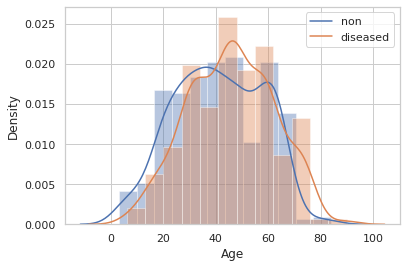

In [242]:
# diseaseの値に応じた"Age"データの抽出
df_Age_non=df_tmp.query("disease==0")["Age"]
df_Age_diseased=df_tmp.query("disease==1")["Age"]

# 2つのデータフレームのヒストグラムを同時に表示
sns.distplot(df_Age_non)
sns.distplot(df_Age_diseased)
# 凡例の表示
plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


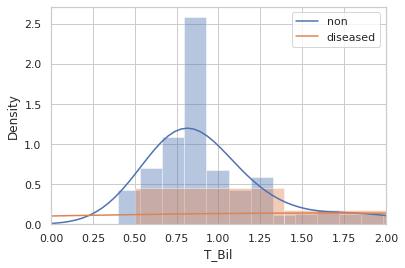

In [243]:
#"T_Bil"データを疾患なしと疾患ありの場合に分ける
df_T_Bil_non = df_tmp.query("disease==0")["T_Bil"]
df_T_Bil_diseased = df_tmp.query("disease==1")["T_Bil"]

#グラフの表示
sns.distplot(df_T_Bil_non)
sns.distplot(df_T_Bil_diseased)
plt.legend(labels = ["non", "diseased"], loc = 'upper right')
plt.xlim(0.0, 2.0)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

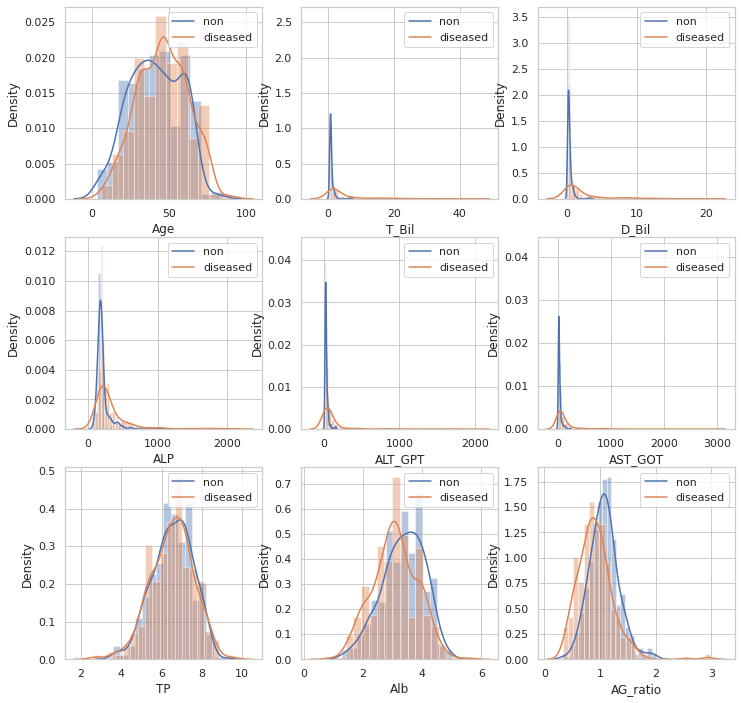

In [244]:
#グラフの表示
plt.figure(figsize=(12, 12))

for ncol, colname in enumerate(df_numeric.columns):
    plt.subplot(3, 3, ncol+1)
    sns.distplot(df_tmp.query("disease==0")[colname])
    sns.distplot(df_tmp.query("disease==1")[colname])
    plt.legend(labels=["non", "diseased"], loc='upper right')
plt.show()

In [245]:
# T_Bil, D_Bilの抽出・表示
print(df[["T_Bil", "D_Bil"]].head(5))

# T_Bil, D_Bilの相関係数
print(df[["T_Bil", "D_Bil"]].corr())

   T_Bil  D_Bil
0    2.9    1.3
1    0.7    0.1
2   23.1   12.5
3    1.0    0.5
4    0.6    0.3
          T_Bil     D_Bil
T_Bil  1.000000  0.992112
D_Bil  0.992112  1.000000


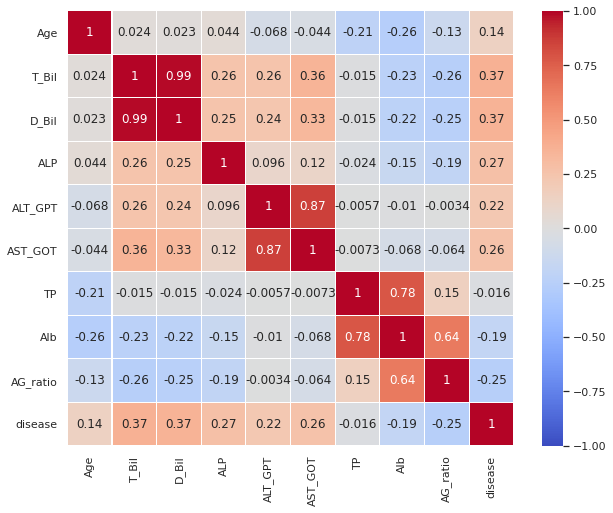

In [246]:
# heatmapの表示
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

In [247]:
# ダミー変数化
df["Gender"] = df["Gender"].apply(lambda x: 1 if x=="Male" else 0)
sub_test["Gender"] = sub_test["Gender"].apply(lambda x: 1 if x=="Male" else 0)

# 説明変数のデータフレーム
X = df.drop(["disease"], axis=1)

# 目的変数のデータフレーム
y = df["disease"]

In [248]:
# データの分割(１回目)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

In [249]:
X_train.loc()

In [250]:
# モデルの学習
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [251]:
print(X_test.shape)
print(sub_test.shape)

(268, 10)
(382, 10)


In [252]:
# 予測
y_pred = lr.predict(X_test)
sub_pre = lr.predict(sub_test)
print("y_predの結果（2値判定の結果）: ", y_pred)

# 予測結果について
print("y_predのサイズ = 評価用データのサイズ = ", y_pred.shape, "\n")
print("疾患あり(1)と判定された数: ", sum(y_pred))

y_predの結果（2値判定の結果）:  [0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1
 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0
 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 1 1 1 0 0 0 0 0]
y_predのサイズ = 評価用データのサイズ =  (268,) 

疾患あり(1)と判定された数:  93


In [253]:
# 疾患あり(=１)となる確率
result_1 =  lr.predict_proba(X_test)[:, 1]
print("疾患ありの確率を抽出した結果（最初の5サンプルだけ表示）")
print(result_1[:5])
print("確率が0.5を超える数 = ", sum(result_1 > 0.5))
print("確率が0.7を超える数 = ", sum(result_1 > 0.7))

疾患ありの確率を抽出した結果（最初の5サンプルだけ表示）
[0.24669217 0.47526159 0.32761973 0.32996874 0.53725913]
確率が0.5を超える数 =  93
確率が0.7を超える数 =  64


0.8651977401129942


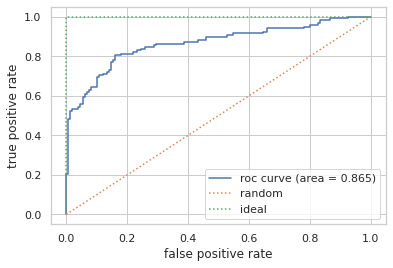

In [254]:
# モデルの予測（疾患あり(=1)に属する確率の算出）
y_pred_prob = lr.predict_proba(X_test)[:, 1]

# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_test, y_score=y_pred_prob)
print(auc_score)

# ROC曲線の要素（偽陽性率、真陽性率、閾値）の算出
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_prob)

# ROC曲線の描画
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [271]:
sub = pd.read_csv('/content/drive/MyDrive/1,データコンペ/SIGNATE/健診データによる肝疾患判定/sample_submit.csv', encoding = 'UTF-8', names=['id', 'pre'])
sub['pre'] = sub_pre
sub.to_csv("/content/drive/MyDrive/1,データコンペ/SIGNATE/健診データによる肝疾患判定/Liver_Disease_Judgment_submit01.csv", header=False, index=False)

In [ ]:
# # binの境界値を指定
# bins_T_Bil = [0, 0.5, 1.0, 100]

# # T_Bil列を分割し、0始まりの連番でラベル化した結果を、X_cutに格納する
# X_cut, bin_indice = pd.cut(X["T_Bil"], bins=bins_T_Bil, retbins=True, labels=False)

# # bin分割した結果をダミー変数化 (prefix=X_Cut.nameは、列名の接頭語を指定している)
# X_dummies = pd.get_dummies(X_cut, prefix=X_cut.name)

# # 元の説明変数のデータフレーム(X)と、ダミー変数化した結果(X_dummies)を横連結
# X_binned = pd.concat([X, X_dummies], axis=1)

# # 結果の確認
# print(X_binned.head())

In [ ]:
# # ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
# fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
# plt.plot(fpr, tpr, label='roc curve')
# plt.plot([0, 1], [0, 1], linestyle=':', label='random')
# plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
# plt.legend()
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.show()

# # AUCスコアの算出
# auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
# print("AUC:", auc_score)

In [ ]:
# # Gender列を除外（数量変数のデータに絞る）
# X_target = X.drop(["Gender"], axis=1)

# # 多項式・交互作用特徴量の生成
# polynomial = PolynomialFeatures(degree=2, include_bias=False)
# polynomial_arr = polynomial.fit_transform(X_target)

# # polynomial_arrのデータフレーム化 （※カラムはshape[1]でpolynomial_arrの列数分だけ出力）
# X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])

# # 生成した多項式・交互作用特徴量の表示
# print(X_polynomial.shape)
# print(X_polynomial.head())

In [ ]:
# # 多項式・交互作用特徴量の生成
# polynomial = PolynomialFeatures(degree=2, include_bias=False)
# polynomial_arr = polynomial.fit_transform(X_target)
# X_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])

# # 組み込み法のモデル、閾値の指定
# fs_model = LogisticRegression(penalty='l2', random_state=0)
# fs_threshold = "mean"
# # 組み込み法モデルの初期化
# selector = SelectFromModel(fs_model, threshold=fs_threshold)

# # 特徴量選択の実行
# selector.fit(X_polynomial, y)
# mask = selector.get_support()
# print(mask)

# # 選択された特徴量だけのサンプル取得
# X_polynomial_masked = X_polynomial.loc[:, mask]

# print("選択された特徴量の表示（最初の5行）")
# print(X_polynomial_masked.head())
# print("選択された特徴量の数の確認")
# print(X_polynomial_masked.shape)

In [ ]:
# # ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
# fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
# plt.plot(fpr, tpr, label='roc curve')
# plt.plot([0, 1], [0, 1], linestyle=':', label='random')
# plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
# plt.legend()
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.show()

# # AUCスコアの算出
# auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
# print("AUC:", auc_score)